In [2]:
from pathlib import Path as pt
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import sigfig
import json

In [1]:
import ipympl

In [24]:
base_loc1 = pt(r'/Users/aravindhnivas/Documents/ML-properties/[PHYSICAL CONSTANTS OF ORGANIC COMPOUNDS]/')
base_loc2 = pt(r'/Users/aravindhnivas/Documents/ML-properties/[CRITICAL CONSTANTS OF ORGANIC COMPOUNDS]/')

processed_data_dirs = [
    base_loc1 / 'tmp_C_processed_data/analysis_data/filtered/tmpC_topelements_processed_data',
    base_loc1 / 'tbp_C_processed_data/analysis_data/filtered/tbp_topelements_processed_data',
    base_loc1 / 'vp_kPa_25C_filtered_ydata_processed_data/analysis_data/filtered/vp_kPa_25C_topelements_processed_data',
    base_loc2 / 'Pc_MPa_processed_data',
    base_loc2 / 'Tc_K_processed_data'
]

plots_dir = pt('/Users/aravindhnivas/Documents/ML-properties/plots/')

titles = [
    'MP (C)', 'BP (C)', 'VP (kPa @25C)', 'P$_c$ (MPa)', 'T$_c$ (K)'
]
total_counts = [7476, 4915, 398, 777, 819]

In [3]:
%matplotlib widget 

In [ ]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=150)

# Flatten the axes array for easy iteration
axes: tuple[plt.Axes] = axes.flatten()

# Plot the bar plots in the subgrid
for i, data_dir in enumerate(processed_data_dirs):
    if i >= 5:  # Ensure we don't exceed the 2x3 grid
        break
    
    analysis_file = data_dir / 'analysis_data/elemental_distribution.csv'
    df_elemental_distribution = pd.read_csv(analysis_file)
    
    # remove counts < 10
    df_elemental_distribution = df_elemental_distribution[df_elemental_distribution['Count'] >= 10]
    
    sns.barplot(data=df_elemental_distribution, x='Element', y='Count', ax=axes[i], legend=False)
    axes[i].set_xlabel('')  # Remove individual X labels
    axes[i].set_ylabel('')  # Remove individual Y labels
    
    _title = f'Dataset: {total_counts[i]}'
    # axes[i].set_title(f'{titles[i]} ({_title})', fontsize=14)  # Set individual titles
    axes[i].set_title(titles[i], fontsize=14)  # Set individual titles
    axes[i].legend([_title], loc='upper left', fontsize=12)
    
    # Add count numbers on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(
            format(p.get_height(), '.0f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            rotation='vertical',
            xytext=(0, 18),  # 9 points vertical offset
            textcoords='offset points'
        )
    
    # increase y-axis limits by 10% to avoid cutting off the top of the bars
    axes[i].set_ylim(0, 1.4 * df_elemental_distribution['Count'].max())
    axes[i].yaxis.set_minor_locator(AutoMinorLocator())
    
    # inset the atomic size distribution plot
    atomic_size_distribution_file = data_dir / 'analysis_data/size_distribution.csv'
    df_atomic_size_distribution = pd.read_csv(atomic_size_distribution_file)
    # df_atomic_size_distribution - columns: 'No. of atoms', 'Count'
    
    # Create inset axes
    # [x0, y0, width, height]
    inset_ax = axes[i].inset_axes([0.5, 0.64, 0.45, 0.35])  # Adjust the position and size as needed
    sns.kdeplot(df_atomic_size_distribution['No. of atoms'], ax=inset_ax, bw_adjust=0.5, fill=True)
    inset_ax.set_xlabel('Atomic Size Distribution', fontsize=10)
    atomic_size_min = df_atomic_size_distribution['No. of atoms'].min()
    atomic_size_max = df_atomic_size_distribution['No. of atoms'].max()
    range_text = f'[{atomic_size_min} - {atomic_size_max}]'
    inset_ax.legend([range_text], loc='upper right', fontsize=8)
    
    inset_ax2 = axes[i].inset_axes([0.5, 0.15, 0.5, 0.35])
    
    df_structural_distribution = pd.read_csv(data_dir / 'analysis_data/structural_distribution.csv')
    inset_ax2.pie(
        df_structural_distribution['Count'], 
        # labels=df_structural_distribution['Structural Category'], 
        autopct='%.0f%%', 
        # autopct=autopct_format,
        startangle=90,
        # pctdistance=1.4
    )
    
    for text in inset_ax2.texts:
        text.set_rotation(text.get_rotation() + 90)
    
# Remove the last subplot (bottom-right) if it exists
if len(processed_data_dirs) < 6:
    fig.delaxes(axes[-1])
    
# Add common X and Y labels
fig.text(0.5, 0.04, 'Elemental Distribution', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=14)

# Adjust layout to ensure plots fit well
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
# fig.savefig(plots_dir / 'elemental_distribution.pdf', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
csv_file = list(processed_data_dirs[0].parent.glob('*.csv'))[0]
df = pd.read_csv(csv_file)
y = df['Processed tmp/ºC']
y.shape, csv_file.name
sns.histplot(y, bins=50, kde=True)

In [ ]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=150)

# Flatten the axes array for easy iteration
axes: tuple[plt.Axes] = axes.flatten()

# Plot the bar plots in the subgrid
for i, data_dir in enumerate(processed_data_dirs):
    if i >= 5:  # Ensure we don't exceed the 2x3 grid
        break
    
    csv_file = data_dir.parent / (data_dir.name.replace('_processed_data', '') + '.csv')
    
    df = pd.read_csv(csv_file)
    y: pd.Series = None
    for col_name in df.columns:
        if col_name.startswith('Processed'):
            y = df[col_name]
            break
    
    if y is None:
        continue
    
    print(data_dir.name, y.shape, csv_file.name)
    
    # histplot with KDE
    sns.histplot(y, bins=50, kde=True, ax=axes[i])  
    axes[i].set_xlabel(titles[i])
    axes[i].set_ylabel('')
    # axes[i].set_title(titles[i], fontsize=14)
    axes[i].minorticks_on()
    
    # set skewness and kurtosis as legend
    skewness = y.skew()
    axes[i].legend([f'Skew: {sigfig.round(skewness, 2)}'], loc='upper left', fontsize=12)
    
    inset_ax = axes[i].inset_axes([0.65, 0.45, 0.3, 0.45])
    stats.probplot(y, dist="norm", plot=inset_ax)
    inset_ax.set_xlabel('')
    inset_ax.set_ylabel('')
    # inset_ax.set_title('')
    inset_ax.set_title('Q-Q Plot')
    
    
# Remove the last subplot (bottom-right) if it exists
if len(processed_data_dirs) < 6:
    fig.delaxes(axes[-1])

# Add common X and Y labels
# fig.text(0.5, 0.04, 'Elemental Distribution', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=14)

# Adjust layout to ensure plots fit well
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
fig.savefig(plots_dir / 'y_distribution.pdf', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
sigfig.round(1.0123456789, 2)

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(18, 12), dpi=150)
# Flatten the axes array for easy iteration
axes: tuple[plt.Axes] = axes.flatten()
ind = 0
dir = processed_data_dirs[ind]

for i, model in enumerate(['gbr', 'xgboost', 'catboost', 'lgbm']):
    ax = axes[i]
    
    # model = 'lgbm'
    embeddings = 'mol2vec_embeddings'
    method = 'default'
    # method = 'best_model'
    if model == 'gbr':
        method = 'best_model'
    pre_trained_filename = f'{model}_{embeddings}_pretrained_model_{method}'
    loc = dir / f'pretrained_models/{model}/{embeddings}/{method}/'

    print(dir.name, model, embeddings, method)
    
    resultsfile = loc / f'{pre_trained_filename}.results.json'
    datfile = loc / f'{pre_trained_filename}.dat.json'

    if not resultsfile.exists() or not datfile.exists():
        continue
    
    results = json.load(open(resultsfile, 'r'))
    data = json.load(open(datfile, 'r'))

    y_true_test = data["test"]["y_true"]
    y_pred_test = data["test"]["y_pred"]
    y_linear_fit_test = data["test"]["y_linear_fit"]

    y_true_train = data["train"]["y_true"]
    y_pred_train = data["train"]["y_pred"]
    # y_linear_fit_train = data["train"]["y_linear_fit"]

    metrics = ["r2", "rmse", "mae"]
    test_scores = {}
    train_scores = {}

    for v in ["test", "train"]:
        for k in metrics:
            mean = results["cv_scores"][v][k]["mean"]
            std = results["cv_scores"][v][k]["std"]
            if v == "test":
                test_scores[k] = sigfig.round(mean, std, sep="external_brackets")
            else:
                train_scores[k] = sigfig.round(mean, std, sep="external_brackets")

    ax.scatter(y_true_train, y_pred_train, color="C0", label="Train", alpha=0.1)
    ax.scatter(y_true_test, y_pred_test, color="C1", label="Test")
    ax.plot(y_true_test, y_linear_fit_test, color="k")
    ax.set_xlabel("True values")
    ax.set_ylabel("Predicted values")

    # Add text annotations for metrics
    textstr_train = "\n".join(
        (
            f"Train ({results['cv_fold']}-fold CV):",
            f'R²: {train_scores["r2"]}',
            f'RMSE: {train_scores["rmse"]}',
            f'MAE: {train_scores["mae"]}',
        )
    )

    textstr_test = "\n".join(
        (
            f"Test ({results['cv_fold']}-fold CV):",
            f'R²: {test_scores["r2"]}',
            f'RMSE: {test_scores["rmse"]}',
            f'MAE: {test_scores["mae"]}',
        )
    )

    ax.text(
        0.05,
        0.95,
        textstr_train,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="C0", alpha=0.5),
    )
    ax.text(
        0.95,
        0.30,
        textstr_test,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(boxstyle="round", facecolor="C1", alpha=0.5),
    )
    # ax.legend()
    ax.set_title(model.upper())
    # ax.legend([f'{embeddings} ({method})'], fontsize=12)

# print(dir.name)
fig.savefig(plots_dir / f'{dir.name}_model_predictions.pdf', dpi=150, bbox_inches='tight')
plt.show()

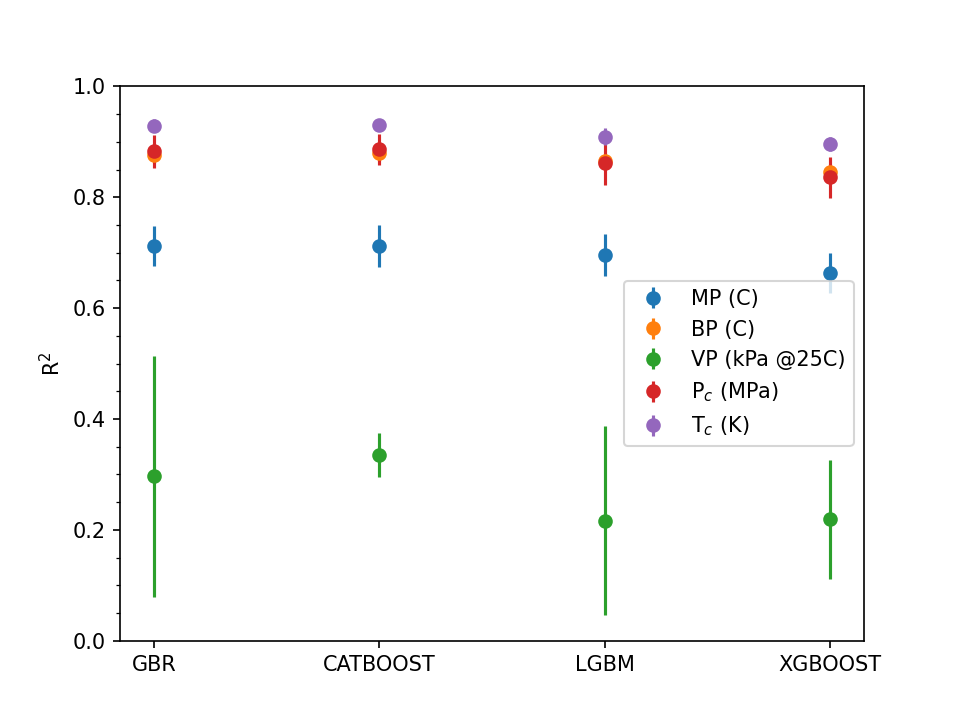

In [81]:
plt.close('all')
fig, ax = plt.subplots(dpi=150)
# models = ['gbr', 'xgboost', 'catboost', 'lgbm']
models = ['gbr', 'catboost', 'lgbm', 'xgboost']
x_models = [x.upper() for x in models]

for i, data_dir in enumerate(processed_data_dirs):
    color = f'C{i}'
    
    # if i == 2:
    #     continue
    
    # for embeddings in ['mol2vec_embeddings', 'VICGAE_embeddings']:
    for embeddings in ['mol2vec_embeddings']:
        # print(embeddings)
        
        y_r2 = []
        y_err_r2 = []
        
        for model in models:
            method = 'default'
            if model == 'gbr':
                method = 'best_model'
                
            pre_trained_filename = f'{model}_{embeddings}_pretrained_model_{method}'
            loc = data_dir / f'pretrained_models/{model}/{embeddings}/{method}/'
            
            # print(data_dir.name, model, embeddings, method)
            name = data_dir.name.replace('_processed_data', '')
            name = name.replace('_topelements', '')
            
            resultsfile = loc / f'{pre_trained_filename}.results.json'
            datfile = loc / f'{pre_trained_filename}.dat.json'

            if not resultsfile.exists() or not datfile.exists():
                continue
            
            results = json.load(open(resultsfile, 'r'))
            metric = 'r2'
            
            r2_mean = float(results["cv_scores"]['test'][metric]["mean"])
            r2_std = float(results["cv_scores"]['test'][metric]["std"])
            
            y_r2.append(r2_mean)
            y_err_r2.append(r2_std)

        
        fmt = 'o'
        if embeddings == 'VICGAE_embeddings':
            fmt = 's'
            
        ax.errorbar(
            x_models, 
            y_r2, 
            yerr=y_err_r2, 
            fmt=fmt,
            c=color, 
            label=f'{titles[i]}'
        )
        
ax.legend()
# ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel('R$^2$')
ax.set_ybound(0.0, 1.0)
fig.savefig(plots_dir / 'r2_scores.pdf', dpi=150, bbox_inches='tight')
plt.show()

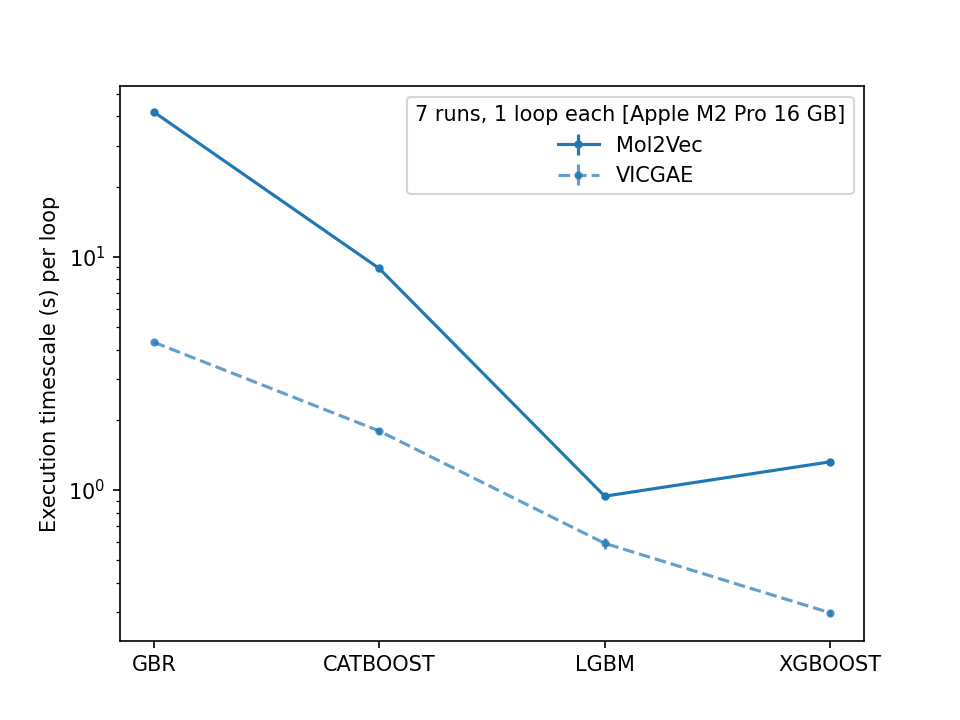

In [89]:
import uncertainties as uc

# [mean, std]
timescales_mol2vec = {
    'gbr': uc.ufloat(41.8, 0.157),
    'catboost': uc.ufloat(8.91, 0.166),
    'lgbm': uc.ufloat(0.94, 0.0216),
    'xgboost': uc.ufloat(1.32, 0.0193)
}

timescales_vicgae = {
    'gbr': uc.ufloat(4.3, 0.0241),
    'catboost': uc.ufloat(1.79, 0.0459),
    'lgbm': uc.ufloat(0.59, 0.0348),
    'xgboost': uc.ufloat(0.297, 0.00801)
}

# for model, ts in timescales_mol2vec.items():
#     ts = ts / uc.ufloat(0.94, 0.0216)
#     print(f'{model}: {ts}')

# print()
# for model, ts in timescales_vicgae.items():
#     ts = ts / uc.ufloat(0.297, 0.00801)
#     print(f'{model}: {ts}')
    

plt.close('all')
fig, ax = plt.subplots(dpi=150)

x_models = [x.upper() for x in timescales_mol2vec.keys()]
y_timescale_mol2vec = [ts.nominal_value for ts in timescales_mol2vec.values()]
y_err_timescale_mol2vec = [ts.std_dev for ts in timescales_mol2vec.values()]

y_timescale_vicgae = [ts.nominal_value for ts in timescales_vicgae.values()]
y_err_timescale_vicgae = [ts.std_dev for ts in timescales_vicgae.values()]

ax.errorbar(x_models, y_timescale_mol2vec, yerr=y_err_timescale_mol2vec, fmt='.-', c='C0', label='Mol2Vec')
ax.errorbar(x_models, y_timescale_vicgae, yerr=y_err_timescale_vicgae, fmt='.--', c='C0', label='VICGAE', alpha=0.7)

ax.legend(title='7 runs, 1 loop each [Apple M2 Pro 16 GB]')
ax.set_ylabel('Execution timescale (s) per loop')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_yscale('log')
# ax.minorticks_on()
fig.savefig(plots_dir / 'execution_timescales.pdf', dpi=150, bbox_inches='tight')
plt.show()

In [72]:
%%timeit
# Code block to measure
result = [x**2 for x in range(1000)]

27.9 μs ± 430 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
